# 量子分类器

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

本教程我们将讨论量子分类器（quantum classifier）的原理，以及如何利用量子神经网络（quantum neural network, QNN）来完成**二分类**任务。这类方法早期工作的主要代表是 Mitarai et al.(2018) 的量子电路学习 [(Quantum Circuit Learning, QCL)](https://arxiv.org/abs/1803.00745) [1], Farhi & Neven (2018) [2] 和 Schuld et al.(2018) 的中心电路量子分类器 [Circuit-Centric Quantum Classifiers](https://arxiv.org/abs/1804.00633) [3]。这里我们以第一类的 QCL 框架应用于监督学习（Supervised learning）为例进行介绍，通常我们需要先将经典数据编码成量子数据，然后通过训练量子神经网络的参数，最终得到一个最优的分类器。

### 背景

在监督学习的情况下，我们需要输入 $N$ 个带标签的数据点构成的数据集 $D = \{(x^k,y^k)\}_{k=1}^{K}$，其中 $x^k\in \mathbb{R}^{m}$ 是数据点，$y^k \in\{0,1\}$ 是对应数据点 $x^k$ 的分类标签。**分类过程实质上是一个决策过程，决策给定数据点的标签归属问题**。 对于量子分类器框架，分类器 $\mathcal{F}$ 的实现方式为一个含参 $\theta$ 的量子神经网络/参数化量子电路, 测量量子系统以及数据后处理的组合。一个优秀的分类器 $\mathcal{F}_\theta$ 应该尽可能的将每个数据集内的数据点正确地映射到相对应的标签上 $\mathcal{F}_\theta(x^k) \rightarrow y^k$。因此，我们将预测标签 $\tilde{y}^{k} = \mathcal{F}_\theta(x^k)$ 和实际标签 $y^k$ 之间的累计距离作为损失函数 $\mathcal{L}(\theta)$ 进行优化。对于两分类任务，可以选择二次损失函数

$$
\mathcal{L}(\theta) = \sum_{k=1}^N 1/N \cdot |\tilde{y}^{k}-y^k|^2. \tag{1}
$$



### 方案流程

这里我们给出实现量子电路学习 (QCL) 框架下量子分类器的一个流程。

1. 将经典数据编码$x^k$为量子数据$\lvert \psi_{\rm in}\rangle^k$。本教程采用角度编码。关于编码方式的具体操作，见[量子态编码经典数据](./DataEncoding_CN.ipynb)。用户也可以尝试其他编码，如振幅编码，体验不同编码方式对分类器学习效率的影响。
2. 构建可调参数量子电路，对应幺正变换(unitary gate)$U(\theta)$。
3. 对每一个量子数据$\lvert\psi_{\rm in}\rangle^k$，通过参数化量子电路$U(\theta)$，得到输出态$\lvert \psi_{\rm out}\rangle^k = U(\theta)\lvert \psi_{\rm in} \rangle^k$。
4. 对每一个量子数据得到的输出量子态$\lvert \psi_{\rm out}\rangle^k$，通过测量与数据后处理，得到标签 $\tilde{y}^{k}$。
5. 重复以上步骤，得到数据集内所有点的标签，并计算损失函数 $\mathcal{L}(\theta)$。
6. 通过梯度下降等优化方法不断调整参数 $\theta$ 的值，从而最小化损失函数。记录优化完成后的最优参数 $\theta^*$, 这时我们就学习到了最优的分类器 $\mathcal{F}_{\theta^*}$。

<img src="./figures/qclassifier-fig-pipeline-cn.png" width="700px" /> 
<center> 图 1：量子分类器训练的流程图 </center>

## Paddle Quantum 实现

这里，我们先导入所需要的语言包：

In [1]:
# 导入 numpy 与 paddle
import numpy as np
import paddle

# 构建量子电路
from paddle_quantum.circuit import UAnsatz
# 一些用到的函数
from numpy import pi as PI
from paddle import matmul, transpose, reshape  # paddle 矩阵乘法与转置
from paddle_quantum.utils import pauli_str_to_matrix,dagger  # 得到 N 量子比特泡利矩阵,复共轭

# 作图与计算时间
from matplotlib import pyplot as plt
import time

C:\Users\yeruilin\Anaconda3\envs\paddle_quantum_env\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


分类器问题用到的参数

In [2]:
# 数据集参数设置
Ntrain = 200        # 规定训练集大小
Ntest = 100         # 规定测试集大小
boundary_gap = 0.5  # 设置决策边界的宽度
seed_data = 2       # 固定随机种子
# 训练参数设置
N = 4               # 所需的量子比特数量
DEPTH = 1           # 采用的电路深度
BATCH = 20          # 训练时 batch 的大小
EPOCH = int(200 * BATCH / Ntrain)
                    # 训练 epoch 轮数，使得总迭代次数 EPOCH * (Ntrain / BATCH) 在200左右
LR = 0.01           # 设置学习速率
seed_paras = 19     # 设置随机种子用以初始化各种参数

### 数据集的生成

对于监督学习来说，我们绕不开的一个问题就是——采用什么样的数据集呢？在这个教程中我们按照论文 [1] 里所提及方法生成简单的圆形决策边界二分数据集 $\{(x^{k}, y^{k})\}$。其中数据点 $x^{k}\in \mathbb{R}^{2}$，标签 $y^{k} \in \{0,1\}$。

<img src="./figures/qclassifier-fig-data-cn.png" width="400px" /> 
<center> 图 2：生成的数据集和对应的决策边界 </center>

具体的生成方式和可视化请见如下代码：

数据集生成函数 

In [4]:
# 圆形决策边界两分类数据集生成器
def circle_data_point_generator(Ntrain, Ntest, boundary_gap, seed_data):
    """
    :param Ntrain: 训练集大小
    :param Ntest: 测试集大小
    :param boundary_gap: 取值于 (0, 0.5), 两类别之间的差距
    :param seed_data: 随机种子
    :return: 四个列表：训练集x，训练集y，测试集x，测试集y
    """
    # 生成共Ntrain + Ntest组数据，x对应二维数据点，y对应编号
    # 取前Ntrain个为训练集，后Ntest个为测试集
    train_x, train_y = [], []
    num_samples, seed_para = 0, 0
    while num_samples < Ntrain + Ntest:
        np.random.seed((seed_data + 10) * 1000 + seed_para + num_samples)
        data_point = np.random.rand(2) * 2 - 1  # 生成[-1, 1]范围内二维向量

        # 如果数据点的模小于(0.7 - gap)，标为0
        if np.linalg.norm(data_point) < 0.7 - boundary_gap / 2:
            train_x.append(data_point)
            train_y.append(0.)
            num_samples += 1

        # 如果数据点的模大于(0.7 + gap)，标为1
        elif np.linalg.norm(data_point) > 0.7 + boundary_gap / 2:
            train_x.append(data_point)
            train_y.append(1.)
            num_samples += 1
        else:
            seed_para += 1

    train_x = np.array(train_x).astype("float64")
    train_y = np.array([train_y]).astype("float64").T

    print("训练集的维度大小 x {} 和 y {}".format(np.shape(train_x[0:Ntrain]), np.shape(train_y[0:Ntrain])))
    print("测试集的维度大小 x {} 和 y {}".format(np.shape(train_x[Ntrain:]), np.shape(train_y[Ntrain:])), "\n")

    return train_x[0:Ntrain], train_y[0:Ntrain], train_x[Ntrain:], train_y[Ntrain:]

数据集可视化函数

In [6]:
# 用以可视化生成的数据集
def data_point_plot(data, label):
    """
    :param data: 形状为 [M, 2], 代表M个 2-D 数据点
    :param label: 取值 0 或者 1
    :return: 画这些数据点
    """
    dim_samples, dim_useless = np.shape(data)
    plt.figure(1)
    for i in range(dim_samples):
        if label[i] == 0:
            plt.plot(data[i][0], data[i][1], color="r", marker="o")
        elif label[i] == 1:
            plt.plot(data[i][0], data[i][1], color="b", marker="o")
    plt.show()

此教程采用大小分别为 200, 100 的训练集，测试集，决策边界宽度为 0.5 的数据，用以训练与测试量子神经网络训练效果：

训练集的维度大小 x (200, 2) 和 y (200, 1)
测试集的维度大小 x (100, 2) 和 y (100, 1) 

训练集 200 个数据点的可视化：


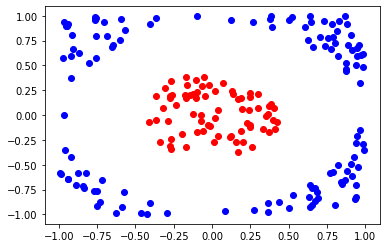

测试集 100 个数据点的可视化：


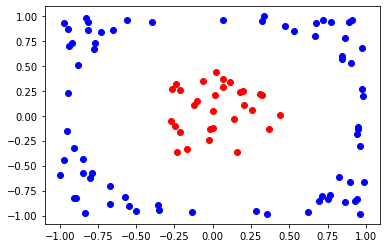


 读者不妨自己调节数据集的参数设置来生成属于自己的数据集吧！


In [7]:
# 生成自己的数据集
train_x, train_y, test_x, test_y = circle_data_point_generator(Ntrain, Ntest, boundary_gap, seed_data)

# 打印数据集的维度信息
print("训练集 {} 个数据点的可视化：".format(Ntrain))
data_point_plot(train_x, train_y)
print("测试集 {} 个数据点的可视化：".format(Ntest))
data_point_plot(test_x, test_y)
print("\n 读者不妨自己调节数据集的参数设置来生成属于自己的数据集吧！")

### 数据的预处理

与经典机器学习不同的是，量子分类器在实际工作的时候需要考虑数据的预处理。我们需要多加一个步骤将经典的数据转化成量子信息才能放在量子计算机上运行。此处我们采用角度编码方式得到量子数据。

首先我们确定需要使用的量子比特数量。因为我们的数据 $\{x^{k} = (x^{k}_0, x^{k}_1)\}$ 是二维的, 按照 Mitarai (2018) 论文[1]中的编码方式我们至少需要2个量子比特。接着准备一系列的初始量子态 $|00\rangle$。然后将经典信息 $\{x^{k}\}$ 编码成一系列量子门 $U(x^{k})$ 并作用在初始量子态上。最终得到一系列的量子态 $|\psi_{\rm in}\rangle^k = U(x^{k})|00\rangle$。这样我们就完成从经典信息到量子信息的编码了！

给定 $m$ 个量子比特去编码二维的经典数据点，采用角度编码，量子门的构造为：

$$
U(x^{k}) = \otimes_{j=0}^{m-1} R_j^z\big[\arccos(x^{k}_{j \, \text{mod} \, 2}\cdot x^{k}_{j \, \text{mod} \, 2})\big] R_j^y\big[\arcsin(x^{k}_{j \, \text{mod} \, 2}) \big],\tag{2}
$$

**注意** ：这种表示下，我们将第一个量子比特编号为 $j = 0$。更多编码方式见 [Robust data encodings for quantum classifiers](https://arxiv.org/pdf/2003.01695.pdf)。读者也可以直接使用量桨中提供的[编码方式](./DataEncoding_CN.ipynb)。这里我们也欢迎读者自己创新尝试全新的编码方式。

由于这种编码的方式看着比较复杂，我们不妨来举一个简单的例子。假设我们给定一个数据点 $x = (x_0, x_1)= (1,0)$, 显然这个数据点的标签应该为 1，对应上图**蓝色**的点。同时数据点对应的2比特量子门 $U(x)$ 是

$$
U(x) = 
\bigg( R_0^z\big[\arccos(x_{0}\cdot x_{0})\big] R_0^y\big[\arcsin(x_{0}) \big]  \bigg)
\otimes 
\bigg( R_1^z\big[\arccos(x_{1}\cdot x_{1})\big] R_1^y\big[\arcsin(x_{1}) \big] \bigg),\tag{3}
$$


把具体的数值带入我们就能得到：
$$
U(x) = 
\bigg( R_0^z\big[0\big] R_0^y\big[\pi/2 \big]  \bigg)
\otimes 
\bigg( R_1^z\big[\pi/2\big] R_1^y\big[0 \big] \bigg),
\tag{4}
$$

以下是常用的旋转门的矩阵形式：


$$
R_x(\theta) :=
\begin{bmatrix}
\cos \frac{\theta}{2} &-i\sin \frac{\theta}{2} \\
-i\sin \frac{\theta}{2} &\cos \frac{\theta}{2}
\end{bmatrix}
,\quad
R_y(\theta) :=
\begin{bmatrix}
\cos \frac{\theta}{2} &-\sin \frac{\theta}{2} \\
\sin \frac{\theta}{2} &\cos \frac{\theta}{2}
\end{bmatrix}
,\quad
R_z(\theta) :=
\begin{bmatrix}
e^{-i\frac{\theta}{2}} & 0 \\
0 & e^{i\frac{\theta}{2}}
\end{bmatrix}.
\tag{5}
$$

那么这个两比特量子门 $U(x)$ 的矩阵形式可以写为：

$$
U(x) = 
\bigg(
\begin{bmatrix}
1 & 0 \\ 
0 & 1
\end{bmatrix}
\begin{bmatrix}
\cos \frac{\pi}{4} &-\sin \frac{\pi}{4} \\ 
\sin \frac{\pi}{4} &\cos \frac{\pi}{4} 
\end{bmatrix}
\bigg)
\otimes 
\bigg(
\begin{bmatrix}
e^{-i\frac{\pi}{4}} & 0 \\ 
0 & e^{i\frac{\pi}{4}}
\end{bmatrix}
\begin{bmatrix}
1 &0 \\ 
0 &1
\end{bmatrix}
\bigg)\, .\tag{6}
$$

化简后我们作用在零初始化的 $|00\rangle$ 量子态上可以得到编码后的量子态 $|\psi_{\rm in}\rangle$，

$$
|\psi_{\rm in}\rangle =
U(x)|00\rangle = \frac{1}{2}
\begin{bmatrix}
1-i &0 &-1+i &0 \\ 
0 &1+i &0  &-1-i \\
1-i &0 &1-i  &0 \\
0 &1+i &0  &1+i 
\end{bmatrix}
\begin{bmatrix}
1 \\
0 \\
0 \\
0
\end{bmatrix}
= \frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}.\tag{7}
$$

接着我们来看看代码上怎么实现这种编码方式。需要注意的是：代码中使用了一个张量积来表述

$$
(U_1 |0\rangle)\otimes (U_2 |0\rangle) = (U_1 \otimes U_2) |0\rangle\otimes|0\rangle
= (U_1 \otimes U_2) |00\rangle.\tag{8}
$$

In [6]:
# 构建绕 Y 轴，绕 Z 轴旋转 theta 角度矩阵
def Ry(theta):
    """
    :param theta: 参数
    :return: Y 旋转矩阵
    """
    return np.array([[np.cos(theta / 2), -np.sin(theta / 2)],
                     [np.sin(theta / 2), np.cos(theta / 2)]])

def Rz(theta):
    """
    :param theta: 参数
    :return: Z 旋转矩阵
    """
    return np.array([[np.cos(theta / 2) - np.sin(theta / 2) * 1j, 0],
                     [0, np.cos(theta / 2) + np.sin(theta / 2) * 1j]])

# 经典 -> 量子数据编码器
def datapoints_transform_to_state(data, n_qubits):
    """
    :param data: 形状为 [-1, 2]，numpy向量形式
    :param n_qubits: 数据转化后的量子比特数量
    :return: 形状为 [-1, 1, 2 ^ n_qubits]
            形状中-1表示第一个参数为任意大小。在此教程实例分析中，对应于BATCH，用以得到Eq.(1)中平方误差的平均值
    """
    dim1, dim2 = data.shape
    res = []
    for sam in range(dim1):
        res_state = 1.
        zero_state = np.array([[1, 0]])
        # 角度编码
        for i in range(n_qubits):
            # 对偶数编号量子态作用 Rz(arccos(x0^2)) Ry(arcsin(x0))
            if i % 2 == 0:
                state_tmp=np.dot(zero_state, Ry(np.arcsin(data[sam][0])).T)
                state_tmp=np.dot(state_tmp, Rz(np.arccos(data[sam][0] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
            # 对奇数编号量子态作用 Rz(arccos(x1^2)) Ry(arcsin(x1))
            elif i % 2 == 1:
                state_tmp=np.dot(zero_state, Ry(np.arcsin(data[sam][1])).T)
                state_tmp=np.dot(state_tmp, Rz(np.arccos(data[sam][1] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
        res.append(res_state)
    res = np.array(res)

    return res.astype("complex128")

测试角度编码下得到的量子数据

In [7]:
print("作为测试我们输入以上的经典信息:")
print("(x_0, x_1) = (1, 0)")
print("编码后输出的2比特量子态为:")
print(datapoints_transform_to_state(np.array([[1, 0]]), n_qubits=2))

作为测试我们输入以上的经典信息:
(x_0, x_1) = (1, 0)
编码后输出的2比特量子态为:
[[[0.5-0.5j 0. +0.j  0.5-0.5j 0. +0.j ]]]


### 构造量子神经网络

那么在完成上述从经典数据到量子数据的编码后，我们现在可以把这些量子态输入到量子计算机里面了。在那之前，我们还需要设计下我们所采用的量子神经网络结构。

<img src="./figures/qclassifier-fig-circuit.png" width="600px" /> 
<center> 图 3：参数化量子神经网络的电路结构 </center>

为了方便，我们统一将上述参数化的量子神经网络称为 $U(\boldsymbol{\theta})$。这个 $U(\boldsymbol{\theta})$ 是我们分类器的关键组成部分，需要一定的复杂结构来拟合我们的决策边界。与经典神经网络类似，量子神经网络的的设计并不是唯一的，这里展示的仅仅是一个例子，读者不妨自己设计出自己的量子神经网络。我们还是拿原来提过的这个数据点 $x = (x_0, x_1)= (1,0)$ 来举例子，编码过后我们已经得到了一个量子态 $|\psi_{\rm in}\rangle$，

$$
|\psi_{\rm in}\rangle =
\frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix},\tag{9}
$$

接着我们把这个量子态输入进我们的量子神经网络，也就是把一个酉矩阵乘以一个向量。得到处理过后的量子态 $|\psi_{\rm out}\rangle$

$$
|\psi_{\rm out}\rangle = U(\boldsymbol{\theta})|\psi_{\rm in}\rangle,\tag{10}
$$

如果我们把所有的参数 $\theta$ 都设置为 $\theta = \pi$, 那么我们就可以写出具体的矩阵了：

$$
|\psi_{\rm out}\rangle = 
U(\boldsymbol{\theta} =\pi)|\psi_{\rm in}\rangle =
\begin{bmatrix}
0  &0 &-1 &0 \\ 
-1 &0 &0  &0 \\
0  &1 &0  &0 \\
0  &0 &0  &1 
\end{bmatrix}
\cdot
\frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}
= \frac{1}{2}
\begin{bmatrix}
-1+i \\
-1+i \\
0 \\
0
\end{bmatrix}.\tag{11}
$$

In [13]:
# 模拟搭建量子神经网络
def cir_Classifier(theta, n, depth):  
    """
    :param theta: 维数: [n, depth + 3] -- 初始增加一层广义旋转门
    :param n: 量子比特数量
    :param depth: 电路深度
    :return: U_theta
    """
    # 初始化网络
    cir = UAnsatz(n)

    # 先搭建广义的旋转层
    for i in range(n):
        cir.rz(theta[i][0], i)
        cir.ry(theta[i][1], i)
        cir.rz(theta[i][2], i)

    # 默认深度为 depth = 1
    # 对每一层搭建电路
    for d in range(3, depth + 3):
        # 搭建纠缠层
        for i in range(n-1):
            cir.cnot([i, i + 1])
        cir.cnot([n-1, 0])
        # 对每一个量子比特搭建Ry
        for i in range(n):
            cir.ry(theta[i][d], i)

    return cir

### 测量

经过量子神经网络$U(\theta)$后，得到是量子态$\lvert \psi_{\rm out}\rangle^k = U(\theta)\lvert \psi_{\rm in} \rangle^k$。要想得到该量子态的标签，我们需要通过测量来得到经典信息。然后再通过这些处理后的经典信息计算损失函数 $\mathcal{L}(\boldsymbol{\theta})$。最后再通过梯度下降算法来不断更新 QNN 参数 $\boldsymbol{\theta}$，并优化损失函数。


这里我们采用的测量方式是测量泡利 $Z$ 算符在第一个量子比特上的期望值。 具体来说，

$$
\langle Z \rangle = 
\langle \psi_{\rm out} |Z\otimes I\cdots \otimes I| \psi_{\rm out}\rangle,\tag{12}
$$

复习一下，泡利 $Z$ 算符的矩阵形式为：

$$
Z := \begin{bmatrix} 1 &0 \\ 0 &-1 \end{bmatrix},\tag{13}
$$

继续我们前面的 2 量子比特的例子，测量过后我们得到的期望值就是：
$$
\langle Z \rangle = 
\langle \psi_{\rm out} |Z\otimes I| \psi_{\rm out}\rangle = 
\frac{1}{2}
\begin{bmatrix}
-1-i \quad
-1-i \quad
0   \quad
0
\end{bmatrix}
\begin{bmatrix}
1  &0 &0  &0 \\ 
0  &1 &0  &0 \\
0  &0 &-1 &0 \\
0  &0 &0  &-1 
\end{bmatrix}
\cdot
\frac{1}{2}
\begin{bmatrix}
-1+i \\
-1+i \\
0 \\
0
\end{bmatrix}
= 1,\tag{14}
$$

好奇的读者或许会问，这个测量结果好像就是我们原来的标签 1 ，这是不是意味着我们已经成功的分类这个数据点了？其实并不然，因为 $\langle Z \rangle$ 的取值范围通常在 $[-1,1]$之间。 为了对应我们的标签范围 $y^{k} \in \{0,1\}$, 我们还需要将区间上下限映射上。这个映射最简单的做法就是让

$$
\tilde{y}^{k} = \frac{\langle Z \rangle}{2} + \frac{1}{2} + bias \quad \in [0, 1].\tag{15}
$$

其中加入偏置（bias）是机器学习中的一个小技巧，目的就是为了让决策边界不受制于原点或者一些超平面。一般我们默认偏置初始化为0，并且优化器在迭代过程中会类似于参数 $\theta$ 一样不断更新偏置确保 $\tilde{y}^{k} \in [0, 1]$。当然读者也可以选择其他复杂的映射（激活函数）比如说 sigmoid 函数。映射过后我们就可以把 $\tilde{y}^{k}$ 看作是我们估计出的标签（label）了。如果 $\tilde{y}^{k}< 0.5$ 就对应标签 0，如果 $\tilde{y}^{k}> 0.5$  就对应标签 1。 我们稍微复习一下整个流程，


$$
x^{k} \rightarrow |\psi_{\rm in}\rangle^{k} \rightarrow U(\boldsymbol{\theta})|\psi_{\rm in}\rangle^{k} \rightarrow
|\psi_{\rm out}\rangle^{k} \rightarrow ^{k}\langle \psi_{\rm out} |Z\otimes I\cdots \otimes I| \psi_{\rm out} \rangle^{k}
\rightarrow \langle Z \rangle  \rightarrow \tilde{y}^{k}.\tag{16}
$$



### 损失函数

相比于公式(1)中损失函数，需要在每次迭代中对所有 Ntrain 个数据点进行测量计算，在实际应用中，我们将训练集中的数据拆分为 "Ntrain/BATCH" 组，其中每组包含BATCH个数据。

对第 i 组数据，训练对应损失函数：
$$
\mathcal{L}_{i} = \sum_{k=1}^{BATCH} \frac{1}{BATCH} |y^{i,k} - \tilde{y}^{i,k}|^2,\tag{17}
$$
并对每一组训练 EPOCH 次。

当取 "BATCH = Ntrain"，此时仅有一组数据点，Eq. (17)重新变为Eq. (1)。


In [8]:
# 生成只作用在第一个量子比特上的泡利 Z 算符
# 其余量子比特上都作用单位矩阵
def Observable(n):
    r"""
    :param n: 量子比特数量
    :return: 局部可观测量: Z \otimes I \otimes ...\otimes I
    """
    Ob = pauli_str_to_matrix([[1.0, 'z0']], n)

    return Ob

In [9]:
# 搭建整个优化流程图
class Opt_Classifier(paddle.nn.Layer):
    """
    创建模型训练网络
    """
    def __init__(self, n, depth, seed_paras=1, dtype='float64'):
        # 初始化部分，通过n, depth给出初始电路
        super(Opt_Classifier, self).__init__()
        self.n = n
        self.depth = depth
        # 初始化参数列表 theta，并用 [0, 2*pi] 的均匀分布来填充初始值
        self.theta = self.create_parameter(
            shape=[n, depth + 3],  # 此处使用量子电路有初始一层广义旋转门，故+3
            default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*PI),
            dtype=dtype,
            is_bias=False)
        # 初始化偏置 (bias)
        self.bias = self.create_parameter(
            shape=[1],
            default_initializer=paddle.nn.initializer.Normal(std=0.01),
            dtype=dtype,
            is_bias=False)

    # 定义前向传播机制、计算损失函数 和交叉验证正确率
    def forward(self, state_in, label):
        """
        输入： state_in：输入量子态，shape: [-1, 1, 2^n] -- 此教程中为[BATCH, 1, 2^n]
               label：输入量子态对应标签，shape: [-1, 1]
        计算损失函数:
                L = 1/BATCH * ((<Z> + 1)/2 + bias - label)^2
        """
        # 将 Numpy array 转换成 tensor
        Ob = paddle.to_tensor(Observable(self.n))
        label_pp = reshape(paddle.to_tensor(label), [-1, 1])

        # 按照随机初始化的参数 theta 
        cir = cir_Classifier(self.theta, n=self.n, depth=self.depth)
        Utheta = cir.U

        # 因为 Utheta是学习到的，我们这里用行向量运算来提速而不会影响训练效果
        state_out = matmul(state_in, Utheta)  # [-1, 1, 2 ** n]形式，第一个参数在此教程中为BATCH

        # 测量得到泡利 Z 算符的期望值 <Z> -- shape [-1,1,1]
        E_Z = matmul(matmul(state_out, Ob), transpose(paddle.conj(state_out), perm=[0, 2, 1]))

        # 映射 <Z> 处理成标签的估计值 
        state_predict = paddle.real(E_Z)[:, 0] * 0.5 + 0.5 + self.bias  # 计算每一个y^{i,k}与真实值得平方差
        loss = paddle.mean((state_predict - label_pp) ** 2)  # 对BATCH个得到的平方差取平均，得到L_i：shape:[1,1]

        # 计算交叉验证正确率
        is_correct = (paddle.abs(state_predict - label_pp) < 0.5).nonzero().shape[0]
        acc = is_correct / label.shape[0]

        return loss, acc, state_predict.numpy(), cir

### 训练过程

好了， 那么定义完以上所有的概念之后我们不妨来看看实际的训练过程！

In [11]:
# 用于绘制最终训练得到分类器的平面分类图
def heatmap_plot(Opt_Classifier, N):
    # 生成数据点 x_y_
    Num_points = 30
    x_y_ = []
    for row_y in np.linspace(0.9, -0.9, Num_points):
        row = []
        for row_x in np.linspace(-0.9, 0.9, Num_points):
            row.append([row_x, row_y])
        x_y_.append(row)
    x_y_ = np.array(x_y_).reshape(-1, 2).astype("float64")

    # 计算预测: heat_data
    input_state_test = paddle.to_tensor(
        datapoints_transform_to_state(x_y_, N))
    loss_useless, acc_useless, state_predict, cir = Opt_Classifier(state_in=input_state_test, label=x_y_[:, 0])
    heat_data = state_predict.reshape(Num_points, Num_points)

    # 画图
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    x_label = np.linspace(-0.9, 0.9, 3)
    y_label = np.linspace(0.9, -0.9, 3)
    ax.set_xticks([0, Num_points // 2, Num_points - 1])
    ax.set_xticklabels(x_label)
    ax.set_yticks([0, Num_points // 2, Num_points - 1])
    ax.set_yticklabels(y_label)
    im = ax.imshow(heat_data, cmap=plt.cm.RdBu)
    plt.colorbar(im)
    plt.show()

通过 Adam 优化器不断学习训练

In [12]:
def QClassifier(Ntrain, Ntest, gap, N, DEPTH, EPOCH, LR, BATCH, seed_paras, seed_data):
    """
    量子二分类器
    输入参数：
        Ntrain,        # 规定训练集大小
        Ntest,         # 规定测试集大小
        gap,           # 设定决策边界的宽度
        N,             # 所需的量子比特数量
        DEPTH,         # 采用的电路深度
        BATCH,         # 训练时 batch 的大小
        EPOCH,         # 训练 epoch 轮数
        LR,            # 设置学习速率
        seed_paras,    # 设置随机种子用以初始化各种参数
        seed_data,     # 固定生成数据集所需要的随机种子
    """
    # 生成训练集测试集
    train_x, train_y, test_x, test_y = circle_data_point_generator(Ntrain=Ntrain, Ntest=Ntest, boundary_gap=gap, seed_data=seed_data)
    # 读取训练集的维度
    N_train = train_x.shape[0]

    paddle.seed(seed_paras)
    # 初始化寄存器存储正确率 acc 等信息
    summary_iter, summary_test_acc = [], []

    # 一般来说，我们利用Adam优化器来获得相对好的收敛
    # 当然你可以改成SGD或者是RMSprop
    myLayer = Opt_Classifier(n=N, depth=DEPTH)  # 得到初始化量子电路
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=myLayer.parameters())


    # 优化循环
    # 此处将训练集分为Ntrain/BATCH组数据，对每一组训练后得到的量子线路作为下一组数据训练的初始量子电路
    # 故通过cir记录每组数据得到的最终量子线路
    i = 0  # 记录总迭代次数
    for ep in range(EPOCH):
        # 将训练集分组，对每一组训练
        for itr in range(N_train // BATCH):
            i += 1  # 记录总迭代次数
            # 将经典数据编码成量子态 |psi>, 维度 [BATCH, 2 ** N]
            input_state = paddle.to_tensor(datapoints_transform_to_state(train_x[itr * BATCH:(itr + 1) * BATCH], N))

            # 前向传播计算损失函数
            loss, train_acc, state_predict_useless, cir \
                = myLayer(state_in=input_state, label=train_y[itr * BATCH:(itr + 1) * BATCH])  # 对此时量子电路优化
            # 显示迭代过程中performance变化
            if i % 30 == 5:
                # 计算测试集上的正确率 test_acc
                input_state_test = paddle.to_tensor(datapoints_transform_to_state(test_x, N))
                loss_useless, test_acc, state_predict_useless, t_cir \
                    = myLayer(state_in=input_state_test,label=test_y)
                print("epoch:", ep, "iter:", itr,
                      "loss: %.4f" % loss.numpy(),
                      "train acc: %.4f" % train_acc,
                      "test acc: %.4f" % test_acc)
                # 存储正确率 acc 等信息
                summary_iter.append(itr + ep * N_train)
                summary_test_acc.append(test_acc) 

            # 反向传播极小化损失函数
            loss.backward()
            opt.minimize(loss)
            opt.clear_grad()

    # 得到训练后电路
    print("训练后的电路：")
    print(cir)
    # 画出 heatmap 表示的决策边界
    heatmap_plot(myLayer, N=N)

    return summary_test_acc

训练集的维度大小 x (200, 2) 和 y (200, 1)
测试集的维度大小 x (100, 2) 和 y (100, 1) 

epoch: 0 iter: 4 loss: 0.1547 train acc: 0.8500 test acc: 0.6400
epoch: 3 iter: 4 loss: 0.1337 train acc: 0.9500 test acc: 0.8800
epoch: 6 iter: 4 loss: 0.1265 train acc: 1.0000 test acc: 1.0000
epoch: 9 iter: 4 loss: 0.1247 train acc: 1.0000 test acc: 1.0000
epoch: 12 iter: 4 loss: 0.1261 train acc: 1.0000 test acc: 1.0000
epoch: 15 iter: 4 loss: 0.1268 train acc: 1.0000 test acc: 1.0000
epoch: 18 iter: 4 loss: 0.1269 train acc: 1.0000 test acc: 1.0000
训练后的电路：
--Rz(0.542)----Ry(3.458)----Rz(2.692)----*--------------x----Ry(6.191)--
                                         |              |               
--Rz(3.514)----Ry(1.543)----Rz(2.499)----x----*---------|----Ry(2.968)--
                                              |         |               
--Rz(5.947)----Ry(3.161)----Rz(3.897)---------x----*----|----Ry(1.579)--
                                                   |    |               
--Rz(0.718)----Ry(5.038)----

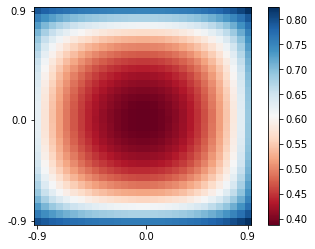

主程序段总共运行了 6.890974283218384 秒


In [13]:
def main():
    """
    主函数
    """
    time_start = time.time()
    acc = QClassifier(
        Ntrain = 200,        # 规定训练集大小
        Ntest = 100,         # 规定测试集大小
        gap = 0.5,           # 设定决策边界的宽度
        N = 4,               # 所需的量子比特数量
        DEPTH = 1,           # 采用的电路深度
        BATCH = 20,          # 训练时 batch 的大小
        EPOCH = int(200 * BATCH / Ntrain),           
                    # 训练 epoch 轮数，使得总迭代次数 EPOCH * (Ntrain / BATCH) 在200左右
        LR = 0.01,           # 设置学习速率
        seed_paras = 19,     # 设置随机种子用以初始化各种参数
        seed_data = 2,       # 固定生成数据集所需要的随机种子
    )
    
    time_span = time.time() - time_start
    print('主程序段总共运行了', time_span, '秒')

if __name__ == '__main__':
    main()

通过打印训练结果可以看到不断优化后分类器在测试集和数据集的正确率都达到了 $100\%$。

## 研究不同的编码方式

监督学习的编码方式对分类结果有很大影响 [4]。在量桨中，我们集成了常用的编码方式，包括振幅编码、角度编码、IQP编码等。 用户可以用内置的 ``SimpleDataset`` 类实例对简单分类数据（不需要降维的数据）进行编码；也可以用内置的 ``VisionDataset`` 类实例对图片数据进行编码。编码的方法都是调用类对象的 ``encode`` 方法。

In [10]:
# 使用前面构建的圆形数据集研究编码
from paddle_quantum.dataset import *

# 用两个量子比特编码二维数据
quantum_train_x = SimpleDataset(2).encode(train_x, 'angle_encoding', 2)
quantum_test_x = SimpleDataset(2).encode(test_x, 'angle_encoding', 2)

print(type(quantum_test_x)) # ndarray
print(quantum_test_x.shape) # (100, 4)

<class 'numpy.ndarray'>
(100, 4)


这里我们对上面的分类器进行化简，之后的所有分类都采用这个分类器。

In [25]:
# 简化的分类器
def QClassifier2(quantum_train_x, train_y,quantum_test_x,test_y, N, DEPTH, EPOCH, LR, BATCH):
    """
    量子二分类分类器
    输入：
        quantum_train_x     # 训练特征
        train_y             # 训练标签
        quantum_test_x      # 测试特征
        test_y              # 测试标签
        N                   # 使用的量子比特数目
        DEPTH               # 分类器电路的深度
        EPOCH               # 迭代次数
        LR                  # 学习率
        BATCH               # 一个批量的大小
    """
    Ntrain = len(quantum_train_x)
    
    paddle.seed(1)

    net = Opt_Classifier(n=N, depth=DEPTH)

    # 测试准确率列表
    summary_iter, summary_test_acc = [], []

    # 这里用 Adam，但是也可以是 SGD 或者 RMSprop
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

    # 进行优化
    for ep in range(EPOCH):
        for itr in range(Ntrain // BATCH):
            # 导入数据
            input_state = quantum_train_x[itr * BATCH:(itr + 1) * BATCH]  # paddle.tensor类型
            input_state = reshape(input_state, [-1, 1, 2 ** N])
            label = train_y[itr * BATCH:(itr + 1) * BATCH]
            test_input_state = reshape(quantum_test_x, [-1, 1, 2 ** N])

            loss, train_acc, state_predict_useless, cir = net(state_in=input_state, label=label)

            if itr % 5 == 0:
                # 获取测试准确率
                loss_useless, test_acc, state_predict_useless, t_cir = net(state_in=test_input_state, label=test_y)
                print("epoch:", ep, "iter:", itr,
                      "loss: %.4f" % loss.numpy(),
                      "train acc: %.4f" % train_acc,
                      "test acc: %.4f" % test_acc)
                summary_test_acc.append(test_acc)

            loss.backward()
            opt.minimize(loss)
            opt.clear_grad()

    return summary_test_acc

现在可以开始用不同编码方式对上面产生的圆形数据进行编码。这里我们采用五种编码方法：振幅编码、角度编码、泡利旋转编码、IQP编码、复杂纠缠编码。然后我们绘制出测试精度曲线以便分析。

In [26]:
# 测试不同编码方式
encoding_list = ['amplitude_encoding', 'angle_encoding', 'pauli_rotation_encoding', 'IQP_encoding', 'complex_entangled_encoding']
num_qubit = 2 # 这里需要小心，如果量子比特数目取 1，可能会报错，因为有 CNOT 门
dimension = 2
acc_list = []

for i in range(len(encoding_list)):
    encoding = encoding_list[i]
    print("Encoding method:", encoding)
    # 用 SimpleDataset 类来编码数据，这里数据维度为 2，编码量子比特数目也是 2
    quantum_train_x= SimpleDataset(dimension).encode(train_x, encoding, num_qubit)
    quantum_test_x= SimpleDataset(dimension).encode(test_x, encoding, num_qubit)
    quantum_train_x = paddle.to_tensor(quantum_train_x)
    quantum_test_x = paddle.to_tensor(quantum_test_x)

    acc = QClassifier2(
            quantum_train_x, # 训练特征
            train_y,         # 训练标签
            quantum_test_x,  # 测试特征
            test_y,          # 测试标签
            N = num_qubit,   # 使用的量子比特数目
            DEPTH = 1,       # 分类器电路的深度
            EPOCH = 1,       # 迭代次数
            LR = 0.1,        # 学习率
            BATCH = 10,      # 一个批量的大小
          )
    acc_list.append(acc)

Encoding method: amplitude_encoding
epoch: 0 iter: 0 loss: 0.3066 train acc: 0.4000 test acc: 0.5400
epoch: 0 iter: 5 loss: 0.2378 train acc: 0.7000 test acc: 0.7000
epoch: 0 iter: 10 loss: 0.2308 train acc: 0.8000 test acc: 0.6700
epoch: 0 iter: 15 loss: 0.2230 train acc: 0.8000 test acc: 0.6100
Encoding method: angle_encoding
epoch: 0 iter: 0 loss: 0.2949 train acc: 0.5000 test acc: 0.3600
epoch: 0 iter: 5 loss: 0.1770 train acc: 0.7000 test acc: 0.7000
epoch: 0 iter: 10 loss: 0.1654 train acc: 0.8000 test acc: 0.7000
epoch: 0 iter: 15 loss: 0.1966 train acc: 0.7000 test acc: 0.5800
Encoding method: pauli_rotation_encoding
epoch: 0 iter: 0 loss: 0.2433 train acc: 0.6000 test acc: 0.7000
epoch: 0 iter: 5 loss: 0.2142 train acc: 0.7000 test acc: 0.7000
epoch: 0 iter: 10 loss: 0.2148 train acc: 0.7000 test acc: 0.7000
epoch: 0 iter: 15 loss: 0.2019 train acc: 0.8000 test acc: 0.7600
Encoding method: IQP_encoding
epoch: 0 iter: 0 loss: 0.2760 train acc: 0.6000 test acc: 0.4200
epoch: 0 i

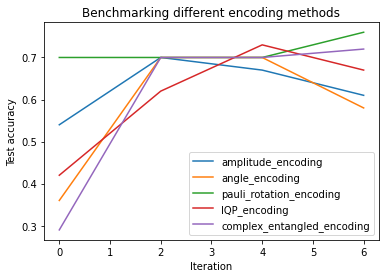

In [27]:
# 绘制五种编码方法的训练曲线
x=[2*i for i in range(len(acc_list[0]))]
for i in range(len(encoding_list)):
    plt.plot(x,acc_list[i])
plt.legend(encoding_list)
plt.title("Benchmarking different encoding methods")
plt.xlabel("Iteration")
plt.ylabel("Test accuracy")
plt.show()

## 用内置的 MNIST 和 Iris 数据集实现量子分类

量桨将常用的分类数据集进行了编码，用户可以使用 `paddle_quantum.dataset` 模块获取编码的量子电路或者量子态。目前集成了4个数据集，包括 MNIST, FashionMNIST, Iris 和 BreastCancer。下面展示如何用这些内置数据集快速实现量子监督学习。

我们从 Iris 数据集开始。Iris 数据集包括三种类别，每种类别有50个样本。数据集中只有四个特征，是比较简单且容易编码的数据集。

epoch: 0 iter: 0 loss: 0.3543 train acc: 0.0000 test acc: 0.0000
epoch: 0 iter: 5 loss: 0.2697 train acc: 0.5000 test acc: 0.5000
epoch: 0 iter: 10 loss: 0.2139 train acc: 1.0000 test acc: 0.9000
epoch: 0 iter: 15 loss: 0.1989 train acc: 0.7500 test acc: 0.9000
epoch: 1 iter: 0 loss: 0.0859 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 5 loss: 0.0432 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 10 loss: 0.0432 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 15 loss: 0.0531 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 0 loss: 0.0374 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 5 loss: 0.0356 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 10 loss: 0.0377 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 15 loss: 0.0440 train acc: 1.0000 test acc: 1.0000
epoch: 3 iter: 0 loss: 0.0317 train acc: 1.0000 test acc: 1.0000
epoch: 3 iter: 5 loss: 0.0344 train acc: 1.0000 test acc: 1.0000
epoch: 3 iter: 10 loss: 0.0384 train acc: 1.0000 test acc: 1.0000
epoch: 3 iter: 15 

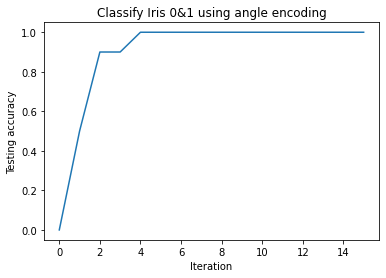

In [32]:
# Iris 数据集二分类

test_rate=0.2
num_qubit=4

# 获取 Iris 数据集的量子态
iris =Iris (encoding='angle_encoding', num_qubits=num_qubit, test_rate=test_rate,classes=[0, 1], return_state=True)

quantum_train_x, train_y = iris.train_x, iris.train_y
quantum_test_x, test_y = iris.test_x, iris.test_y
testing_data_num = len(test_y)
training_data_num = len(train_y)

acc = QClassifier2(
        quantum_train_x, # 训练特征
        train_y,         # 训练标签
        quantum_test_x,  # 测试特征
        test_y,          # 测试标签
        N = num_qubit,   # 使用的量子比特数目
        DEPTH = 1,       # 分类器电路的深度
        EPOCH = 4,       # 迭代次数
        LR = 0.1,        # 学习率
        BATCH = 4,      # 一个批量的大小
      )
plt.plot(acc)
plt.title("Classify Iris 0&1 using angle encoding")
plt.xlabel("Iteration")
plt.ylabel("Testing accuracy")
plt.show()

第二个例子为 MNIST 数据集。 MNIST 是手写数字数据集，有 0-9 十个类别（每一类训练集中有 6000 个样本，测试集中有 1000 个样本）。所有的图片都是 $28\times28$ 的灰度图，所以需要使用 ``resize`` 或 ``PCA`` 降维到目标维度 ``target_dimension`` 。

epoch: 0 iter: 0 loss: 0.3237 train acc: 0.3250 test acc: 0.5450
epoch: 0 iter: 5 loss: 0.2124 train acc: 0.7500 test acc: 0.6500
epoch: 0 iter: 10 loss: 0.2294 train acc: 0.6500 test acc: 0.6850
epoch: 1 iter: 0 loss: 0.1970 train acc: 0.7250 test acc: 0.7850
epoch: 1 iter: 5 loss: 0.1521 train acc: 0.8500 test acc: 0.8150
epoch: 1 iter: 10 loss: 0.1726 train acc: 0.7750 test acc: 0.8900
epoch: 2 iter: 0 loss: 0.1742 train acc: 0.7250 test acc: 0.8650
epoch: 2 iter: 5 loss: 0.1167 train acc: 0.9000 test acc: 0.8900
epoch: 2 iter: 10 loss: 0.1654 train acc: 0.8000 test acc: 0.8950
epoch: 3 iter: 0 loss: 0.1609 train acc: 0.8000 test acc: 0.8850
epoch: 3 iter: 5 loss: 0.1148 train acc: 0.9250 test acc: 0.8850
epoch: 3 iter: 10 loss: 0.1649 train acc: 0.8000 test acc: 0.8750
epoch: 4 iter: 0 loss: 0.1629 train acc: 0.8250 test acc: 0.8750
epoch: 4 iter: 5 loss: 0.1112 train acc: 0.9000 test acc: 0.8700
epoch: 4 iter: 10 loss: 0.1630 train acc: 0.8500 test acc: 0.8850


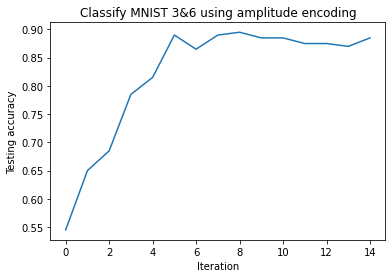

In [20]:
# 使用 MNIST 进行分类

# 主要参数
training_data_num = 500
testing_data_num = 200
qubit_num = 4

# 选择3和6两个类，将 MNIST 从 28*28 重采样为 4*4，再用振幅编码方式进行编码 
train_dataset = MNIST(mode='train', encoding='amplitude_encoding', num_qubits=qubit_num, classes=[3,6],
                      data_num=training_data_num,need_cropping=True,
                      downscaling_method='resize', target_dimension=16, return_state=True)

val_dataset = MNIST(mode='test', encoding='amplitude_encoding', num_qubits=qubit_num, classes=[3,6],
                    data_num=testing_data_num,need_cropping=True,
                    downscaling_method='resize', target_dimension=16,return_state=True)

quantum_train_x, train_y = train_dataset.quantum_image_states, train_dataset.labels
quantum_test_x, test_y = val_dataset.quantum_image_states, val_dataset.labels

acc = QClassifier2(
        quantum_train_x, # 训练特征
        train_y,         # 训练标签
        quantum_test_x,  # 测试特征
        test_y,          # 测试标签
        N = num_qubit,   # 使用的量子比特数目
        DEPTH = 3,       # 分类器电路的深度
        EPOCH = 5,       # 迭代次数
        LR = 0.1,        # 学习率
        BATCH = 40,      # 一个批量的大小
      )
plt.plot(acc)
plt.title("Classify MNIST 3&6 using amplitude encoding")
plt.xlabel("Iteration")
plt.ylabel("Testing accuracy")
plt.show()

---

## 参考文献

[1] Mitarai, Kosuke, et al. Quantum circuit learning. [Physical Review A 98.3 (2018): 032309.](https://arxiv.org/abs/1803.00745)

[2] Farhi, Edward, and Hartmut Neven. Classification with quantum neural networks on near term processors. [arXiv preprint arXiv:1802.06002 (2018).](https://arxiv.org/abs/1802.06002)

[3] Schuld, Maria, et al. Circuit-centric quantum classifiers. [Physical Review A 101.3 (2020): 032308.](https://arxiv.org/abs/1804.00633)

[4] Schuld, Maria. Supervised quantum machine learning models are kernel methods. [arXiv preprint arXiv:2101.11020 (2021).](https://arxiv.org/pdf/2101.11020)